# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, Binarizer, KBinsDiscretizer, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [4]:
PATH = "./data/"
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [5]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [7]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [10]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

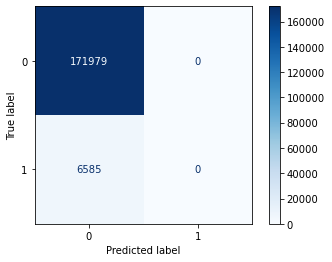

In [11]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [12]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

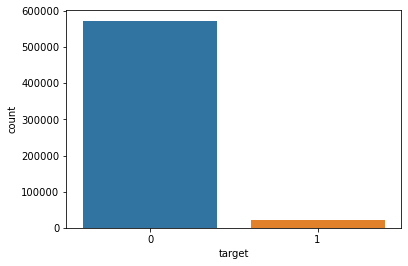

In [13]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [14]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normilized Gini Coefficient** is equivalent to **2 x AUC - 1** :

#### Geometric explanation
**Normilized Gini coefficient** adjusts the score by the theoretical maximum so that the maximum score is 1. It can be thought of as the ratio of the area of our imperfect model (marked A in the diagram) over the total area under the line of equality or the line of the theoretical maximum (marked A and B in the diagram): *G = A/(A + B)*, where A + B is the square of a perferct model.

Since the axes scale from 0 to 1, then it is true: *A + B = 0.5*

Hence: *G = A/(A + (0.5 - A) = A / 0.5*. Then *G = 2A*.

**AUC** is the area under the ROC curve. It shows relationshop between between True Positive Rate and False Positive Rate.


*AUC = 0.5 + A* (see the diagram).

Hence, *A = AUC - 0.5*

**Final steps:**
*G = 2A* and *A = AUC - 0.5* => G = 2(AUC - 0.5) = 2AUC - 1.

So it was proved that G = 2AUC - 1.

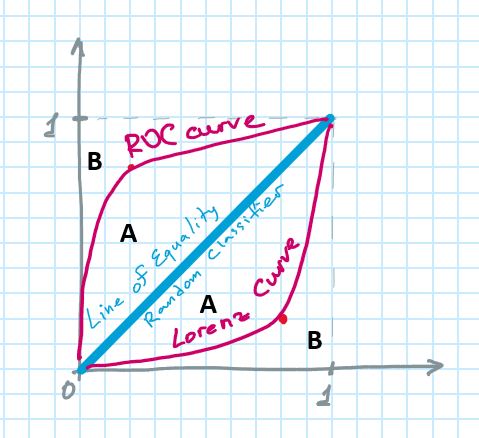

In [15]:
from IPython.display import Image
Image("ROCvsGini.PNG")

#### Analytical

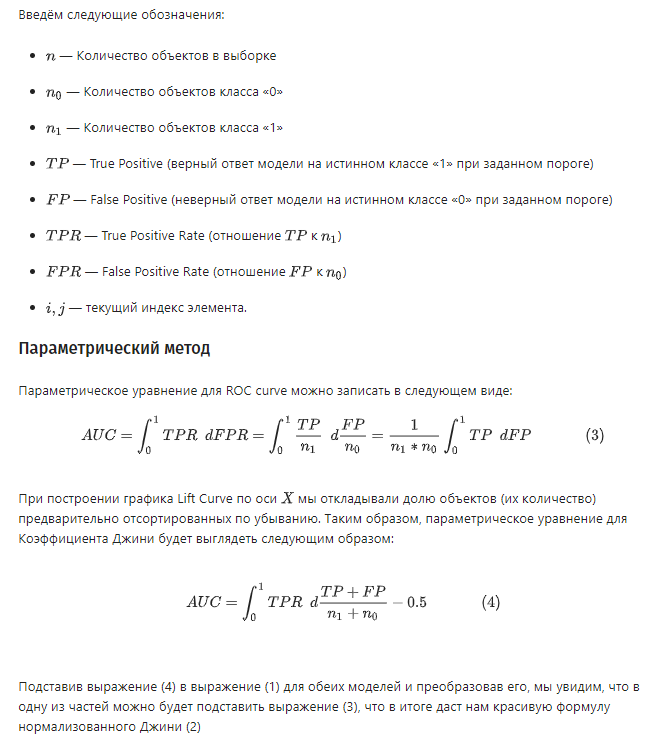

In [16]:
from IPython.display import Image
Image("nGini.PNG")

*Sources:*
1. https://en.wikipedia.org/wiki/Receiver_operating_characteristic
2. Hand, D.J., Till, R.J. A Simple Generalisation of the Area Under the ROC Curve for Multiple Class Classification Problems. Machine Learning 45, 171–186 (2001). https://doi.org/10.1023/A:1010920819831
3. https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation
4. https://habr.com/ru/company/ods/blog/350440/

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

The choice of the correct metric for unbalanced data used for classification plays pivotal role. So due care should be taken.
The other metrics which could be used are follows:
- Confusion matrix for overall assesment;

- Precision-Recall curves (https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/):
    
    Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.
    
    Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.
    
    There are also composite scores that attempt to summarize the precision and recall:
    F-Measure or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are rates); Area Under Curve under the precision-recall curve.
    

- Kappa (https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english and https://www.standardwisdom.com/2011/12/29/confusion-matrix-another-single-value-metric-kappa-statistic/):
    Kappa = (observed accuracy - expected accuracy)/(1 - expected accuracy)

Let's calculate the Normalized Gini Coefficient:

In [17]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [18]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

### При подготовке данной домашней работы я применяла разные подходы. овер/андер сэмплинг, фичи подбирала, убирала те, где были 0 коэффициенты при L1 регуляризации и т.п. Выложила ниже несколько работ.
### Модель, которая дала наибольший скорр - Model 3. private score - 0.26365


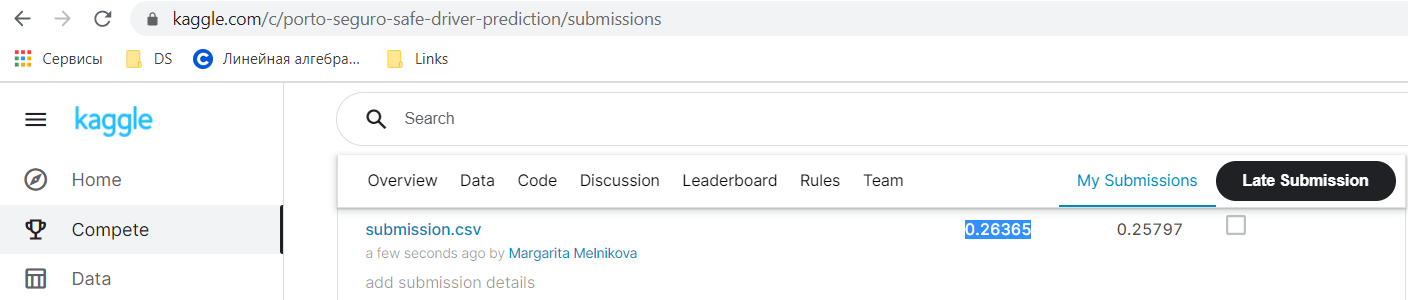

In [19]:
from IPython.display import Image
Image("PortoScore.PNG")

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, Binarizer, KBinsDiscretizer, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report

## Model 3. nGini =0.2807663434031586, private score - 0.26365

In [21]:
### Model concept with train/test split

In [22]:
# The classes are unbalanced, so let's make dataset balanced
porto_1 = insurance_data[insurance_data['target'] == 1]
rows_n = porto_1['target'].count()
porto_0 = insurance_data[insurance_data['target'] == 0]
porto_0 = porto_0.sample(n=rows_n, random_state=42)
porto = pd.concat([porto_1, porto_0]) 

In [23]:
# defining data for modelling
y = porto['target']
X = porto.drop(columns=['target', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
                      'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
                      'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
                      'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
                      'ps_calc_19_bin', 'ps_calc_20_bin'])

In [24]:
# X.columns

In [25]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l1', C=1))])

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
clf = pipeline.fit(X_train, y_train)

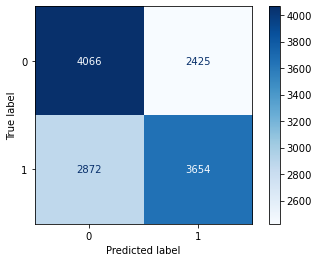

In [28]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [29]:
y_pred = clf.predict_proba(X)[:, 1]
gini_normalized(y, y_pred)

0.2771662046307338

In [30]:
### Model trained on full dataset wCV

In [31]:
clf = pipeline.fit(X, y)

In [32]:
# and cross-validation according to the requirements
accuracy = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5).mean()
print('accuracy: ', accuracy)

accuracy:  0.5930210420041933


In [33]:
y_pred = clf.predict_proba(X)[:, 1]
gini_normalized(y, y_pred)

0.2807702105629392

#### Predict

In [34]:
data_test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [35]:
x_test = data_test.drop(columns=['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
                      'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
                      'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
                      'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
                      'ps_calc_19_bin', 'ps_calc_20_bin'])

In [36]:
Prediction_Test = pipeline.predict_proba(x_test)[:,1]

In [37]:
output_pd = x_test.copy()
output_pd['target'] = Prediction_Test
# output_pd

In [38]:
output = pd.DataFrame({'id': output_pd.index,'target': output_pd['target']})
output.to_csv('submission.csv', index=False)

# ========== Models below are kept for history and to show different approaches I took ==========

## Model 1. nGini = 0.2712526454764119

In [39]:
### Model concept with train/test split

In [40]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
clf = pipeline.fit(X_train, y_train)

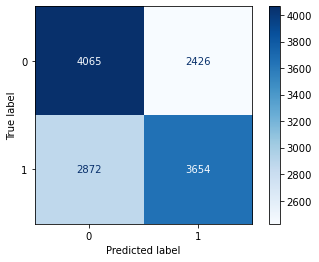

In [43]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [44]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [45]:
gini_normalized(y_valid, y_pred)

0.2741273626340117

In [46]:
### Model trained on full dataset wCV

In [47]:
clf = pipeline.fit(X, y)

In [48]:
# and cross-validation according to the requirements
accuracy = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5).mean()
print('accuracy: ', accuracy)

accuracy:  0.5930671382302178


In [49]:
y_pred = clf.predict_proba(X)[:, 1]
gini_normalized(y, y_pred)

0.28077196990815817

## Model 2. nGini = 0.2811366813221281, private score 0.26310

In [50]:
### Model concept with train/test split

In [51]:
# The classes are unbalanced, so let's make dataset balanced
porto_1 = insurance_data[insurance_data['target'] == 1]
rows_n = porto_1['target'].count()
porto_0 = insurance_data[insurance_data['target'] == 0]
porto_0 = porto_0.sample(n=rows_n, random_state=42)
porto = pd.concat([porto_1, porto_0]) 

In [52]:
# defining data for modelling
y = porto['target']
X = porto.drop(columns=['target'])

In [53]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
clf = pipeline.fit(X_train, y_train)

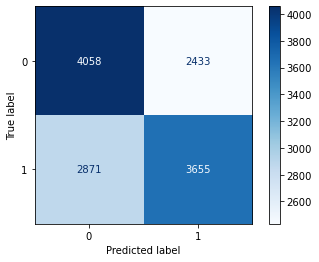

In [56]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [57]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [58]:
gini_normalized(y_valid, y_pred)

0.27281311215216375

In [59]:
### Model trained on full dataset wCV

In [60]:
clf = pipeline.fit(X, y)

In [61]:
# and cross-validation according to the requirements
accuracy = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5).mean()
print('accuracy: ', accuracy)

accuracy:  0.5912694677536646


In [62]:
y_pred = clf.predict_proba(X)[:, 1]
gini_normalized(y, y_pred)

0.28113646459119507

## Model 4. nGini =0.2710853887001175

In [63]:
### Model concept with train/test split

In [64]:
# defining data for modelling
# delete calc columns - see details in EDA section below
y = insurance_data['target']
X = insurance_data.drop(columns=['target', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
                      'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
                      'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
                      'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
                      'ps_calc_19_bin', 'ps_calc_20_bin'])

In [65]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
clf = pipeline.fit(X_train, y_train)

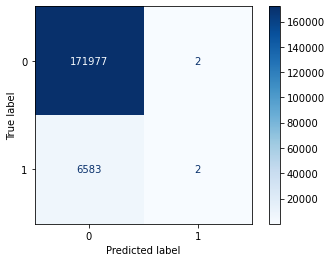

In [68]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

In [69]:
y_pred = clf.predict_proba(X)[:, 1]
gini_normalized(y, y_pred)

0.2696250420696234

In [70]:
### Model trained on full dataset wCV

In [71]:
clf = pipeline.fit(X, y)

In [72]:
# and cross-validation according to the requirements
accuracy = cross_val_score(pipeline, X, y, scoring='accuracy', cv=5).mean()
print('accuracy: ', accuracy)

accuracy:  0.9635457618568726


In [73]:
y_pred = clf.predict_proba(X)[:, 1]
gini_normalized(y, y_pred)

0.27109956322387996

# Model 5. nGini = 0.25860583592735226, private score 0.25024
# EDA

In [74]:
porto_data = insurance_data.copy()

In [75]:
# Descriptive statistics
# porto_data.describe() #under comment for reviewwer's convenience

In [76]:
# porto_data.dtypes #under comment for reviewwer's convenience

In [77]:
# for col in porto_data.columns:
#     print(col, ": ", porto_data[col].unique())  #under comment for reviewwer's convenience

- We see that there are some 'calc' columns which I would investigate later.
- Also we need to examine numerical columns with int64 and float64 types separately (continuous and ordinal).
- And Binary and Categorical features are to be reviewed.

### Missing values

In [78]:
# Let's examine missing values
## Values of -1 indicate that the feature was missing from the observation. 
porto_data = porto_data.replace(-1, np.NaN)

In [79]:
# Columns with missing values
## Most of them are categorical
missing_cols = porto_data.isnull().mean()
missing_cols = missing_cols[missing_cols > 0].keys() 
missing_cols

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12',
       'ps_car_14'],
      dtype='object')

In [80]:
porto_data[missing_cols].isnull().sum() / len(porto_data)

ps_ind_02_cat    0.000363
ps_ind_04_cat    0.000139
ps_ind_05_cat    0.009760
ps_reg_03        0.181065
ps_car_01_cat    0.000180
ps_car_02_cat    0.000008
ps_car_03_cat    0.690898
ps_car_05_cat    0.447825
ps_car_07_cat    0.019302
ps_car_09_cat    0.000956
ps_car_11        0.000008
ps_car_12        0.000002
ps_car_14        0.071605
dtype: float64

In [81]:
porto_data[['target', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12',
       'ps_car_14']].corr()['target']

target           1.000000
ps_ind_02_cat    0.005574
ps_ind_04_cat    0.010146
ps_ind_05_cat    0.032254
ps_reg_03        0.033758
ps_car_01_cat    0.017290
ps_car_02_cat   -0.031545
ps_car_03_cat    0.020729
ps_car_05_cat    0.000871
ps_car_07_cat   -0.019735
ps_car_09_cat    0.006013
ps_car_11       -0.001220
ps_car_12        0.038800
ps_car_14        0.011674
Name: target, dtype: float64

In [82]:
# ps_car_05_cat and ps_car_03_cat have high %% of misising data and insignificant correlation with a target
# so I would drop the features
porto_data = porto_data.drop(columns=['ps_car_05_cat', 'ps_car_03_cat'])
porto_data.columns

Index(['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')

### Calc Columns

In [83]:
# Examine features with calc
extract = porto_data[['target', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
                      'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
                      'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
                      'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
                      'ps_calc_19_bin', 'ps_calc_20_bin']]
extract.corr(method='pearson')['target']

target            1.000000
ps_calc_01        0.001782
ps_calc_02        0.001360
ps_calc_03        0.001907
ps_calc_04        0.000033
ps_calc_05        0.000771
ps_calc_06        0.000082
ps_calc_07       -0.000103
ps_calc_08       -0.001006
ps_calc_09        0.000719
ps_calc_10        0.001061
ps_calc_11        0.000371
ps_calc_12       -0.001133
ps_calc_13       -0.000446
ps_calc_14        0.001362
ps_calc_15_bin   -0.000490
ps_calc_16_bin    0.000624
ps_calc_17_bin   -0.000170
ps_calc_18_bin    0.000552
ps_calc_19_bin   -0.001744
ps_calc_20_bin   -0.001072
Name: target, dtype: float64

In [84]:
# Correlaton is not material, so I would drop these features
porto_data = porto_data.drop(columns=[ 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
                      'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
                      'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
                      'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
                      'ps_calc_19_bin', 'ps_calc_20_bin'])

### Binary features

In [85]:
bin_features = [column for column in porto_data if column.endswith("bin")]
extract = porto_data[bin_features]

In [86]:
extract.columns.to_list()

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

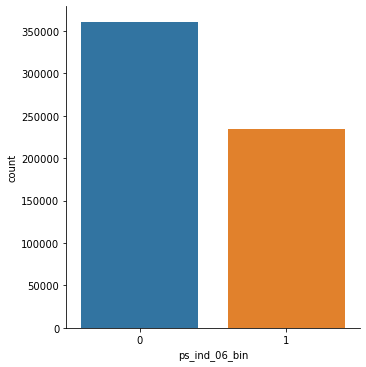

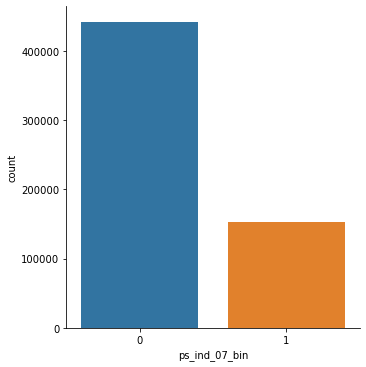

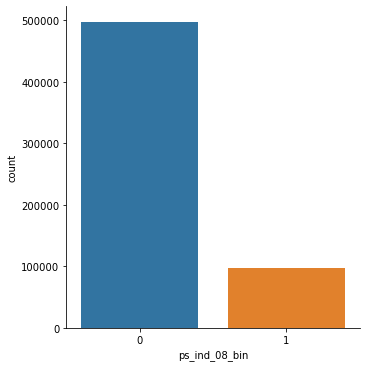

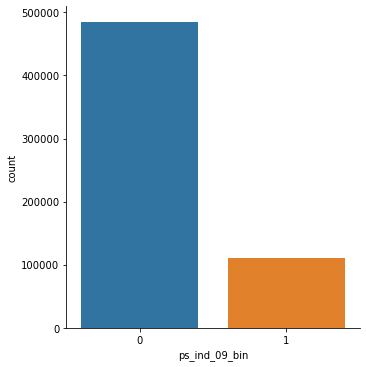

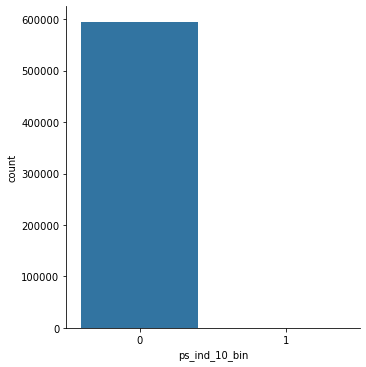

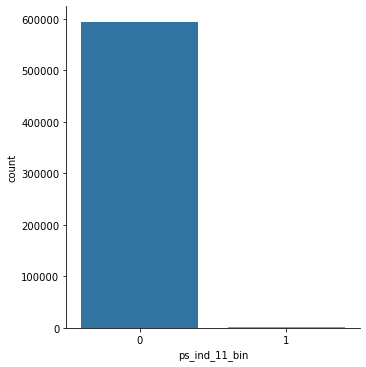

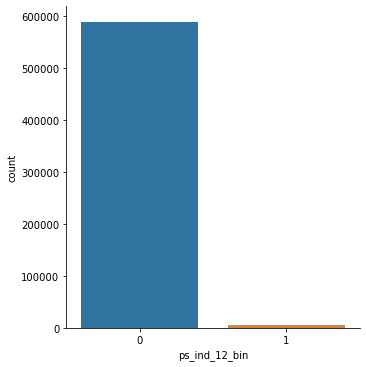

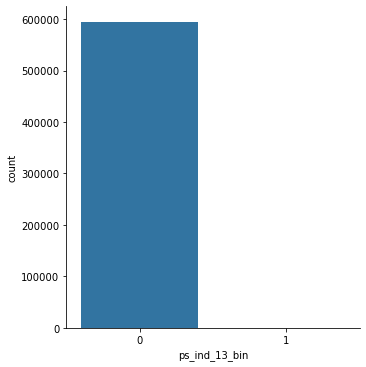

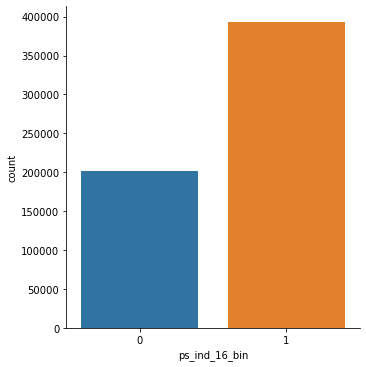

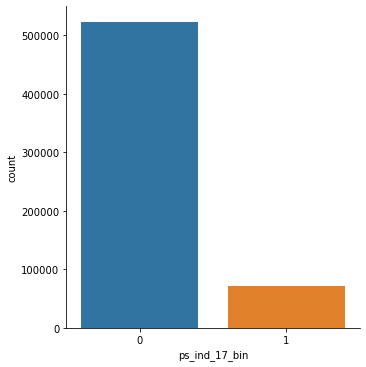

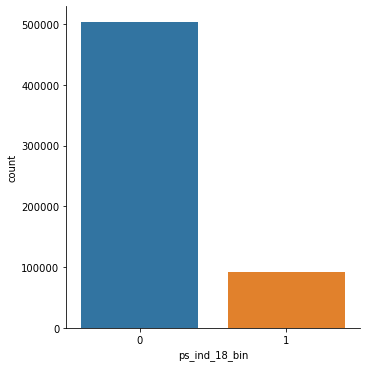

In [87]:
for col in bin_features:
    sns.catplot(x=col, kind="count", data=extract)

In [88]:
# Let's check features which have almost zero or zero variance in their own distributions for correlation with a target
porto_data[['target', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin']].corr()['target']

target           1.000000
ps_ind_10_bin    0.001815
ps_ind_11_bin    0.002028
ps_ind_12_bin    0.007810
ps_ind_13_bin    0.002460
Name: target, dtype: float64

In [89]:
# The observed features would not add any value to the model, so I would exclude them
porto_data = porto_data.drop(columns=['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin'])

In [90]:
bin_features = [column for column in porto_data if column.endswith("bin")]
extract = porto_data[bin_features]

<AxesSubplot:>

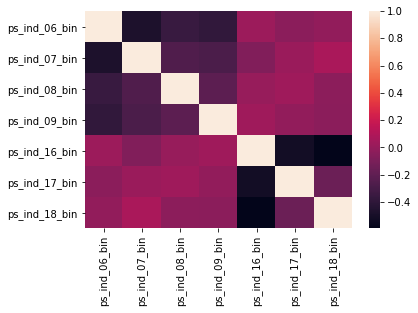

In [91]:
sns.heatmap(extract.corr())

In [92]:
extract.corr()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
ps_ind_06_bin,1.000000,-0.474009,-0.356838,-0.384345,0.028352,-0.037121,-0.011751
ps_ind_07_bin,-0.474009,1.000000,-0.260438,-0.280513,-0.072321,0.020776,0.076562
ps_ind_08_bin,-0.356838,-0.260438,1.000000,-0.211173,0.005855,0.036036,-0.033273
ps_ind_09_bin,-0.384345,-0.280513,-0.211173,1.000000,0.040109,-0.011023,-0.039631
ps_ind_16_bin,0.028352,-0.072321,0.005855,0.040109,1.000000,-0.518076,-0.594265
ps_ind_17_bin,-0.037121,0.020776,0.036036,-0.011023,-0.518076,1.000000,-0.158021
ps_ind_18_bin,-0.011751,0.076562,-0.033273,-0.039631,-0.594265,-0.158021,1.000000


In [93]:
porto_data[['target', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_ind_16_bin']].corr()

,target,ps_ind_17_bin,ps_ind_18_bin,ps_ind_16_bin
target,1.000000,0.037053,0.004555,-0.027778
ps_ind_17_bin,0.037053,1.000000,-0.158021,-0.518076
ps_ind_18_bin,0.004555,-0.158021,1.000000,-0.594265
ps_ind_16_bin,-0.027778,-0.518076,-0.594265,1.000000


In [94]:
porto_data[['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin']].corr()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin
target,1.000000,-0.034017,0.034218,0.013147,-0.008237
ps_ind_06_bin,-0.034017,1.000000,-0.474009,-0.356838,-0.384345
ps_ind_07_bin,0.034218,-0.474009,1.000000,-0.260438,-0.280513
ps_ind_08_bin,0.013147,-0.356838,-0.260438,1.000000,-0.211173
ps_ind_09_bin,-0.008237,-0.384345,-0.280513,-0.211173,1.000000


In [95]:
# according to the abalysis above I would suggest to keep 'ps_ind_17_bin' and 'ps_ind_07_bin' to avoid multicollinearity
# and reduce number of dimentions in the model to avoid curce of dimentiality
porto_data = porto_data.drop(columns=['ps_ind_18_bin', 'ps_ind_16_bin', 'ps_ind_06_bin', 'ps_ind_08_bin', 'ps_ind_09_bin'])

In [96]:
bin_features = [column for column in porto_data if column.endswith("bin")]
bin_features
# So only 2 binary features are left. Yahoo! :)

['ps_ind_07_bin', 'ps_ind_17_bin']

### Category features

In [97]:
cat_features = [column for column in porto_data if column.endswith("cat")]
extract = porto_data[cat_features]

In [98]:
extract.columns.to_list()

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [99]:
for col in extract.columns:
    print(col, ": ", porto_data[col].unique())  #under comment for reviewwer's convenience

ps_ind_02_cat :  [ 2.  1.  4.  3. nan]
ps_ind_04_cat :  [ 1.  0. nan]
ps_ind_05_cat :  [ 0.  1.  4.  3.  6.  5. nan  2.]
ps_car_01_cat :  [10. 11.  7.  6.  9.  5.  4.  8.  3.  0.  2.  1. nan]
ps_car_02_cat :  [ 1.  0. nan]
ps_car_04_cat :  [0 1 8 9 2 6 3 7 4 5]
ps_car_06_cat :  [ 4 11 14 13  6 15  3  0  1 10 12  9 17  7  8  5  2 16]
ps_car_07_cat :  [ 1. nan  0.]
ps_car_08_cat :  [0 1]
ps_car_09_cat :  [ 0.  2.  3.  1. nan  4.]
ps_car_10_cat :  [1 0 2]
ps_car_11_cat :  [ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


<AxesSubplot:>

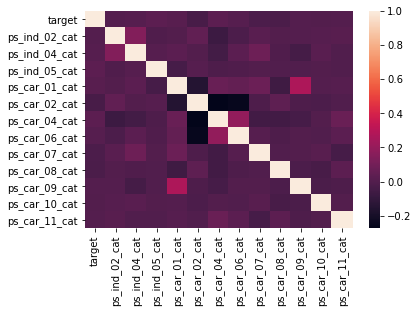

In [100]:
sns.heatmap(porto_data[['target', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat',
 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']].corr())

In [101]:
porto_data[['target', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat']].corr()

,target,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat
target,1.000000,0.017290,-0.031545,0.032900,0.011537
ps_car_01_cat,0.017290,1.000000,-0.153029,0.068418,0.053344
ps_car_02_cat,-0.031545,-0.153029,1.000000,-0.273626,-0.253099
ps_car_04_cat,0.032900,0.068418,-0.273626,1.000000,0.194015
ps_car_06_cat,0.011537,0.053344,-0.253099,0.194015,1.000000


In [102]:
# according to the abalysis above I would suggest to delete 'ps_car_02_cat' and 'ps_car_06_cat' to avoid multicollinearity
# and reduce number of dimentions in the model to avoid curce of dimentiality
porto_data = porto_data.drop(columns=['ps_car_02_cat', 'ps_car_06_cat'])

In [103]:
cat_features = [column for column in porto_data if column.endswith("cat")]
extract = porto_data[cat_features]

In [104]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_04_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

<AxesSubplot:>

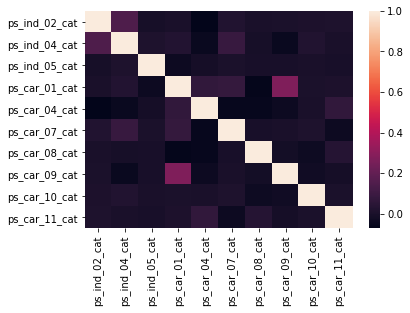

In [105]:
# for col in cat_features:
#     sns.catplot(x=col, kind="count", data=extract)
sns.heatmap(extract.corr())

In [106]:
porto_data[['target', 'ps_car_01_cat', 'ps_car_09_cat']].corr()

,target,ps_car_01_cat,ps_car_09_cat
target,1.000000,0.017290,0.006013
ps_car_01_cat,0.017290,1.000000,0.273547
ps_car_09_cat,0.006013,0.273547,1.000000


In [107]:
# according to the abalysis above I would suggest to delete 'ps_car_02_cat' and 'ps_car_06_cat' to avoid multicollinearity
# and reduce number of dimentions in the model to avoid curce of dimentiality
porto_data = porto_data.drop(columns=['ps_car_09_cat'])

<AxesSubplot:>

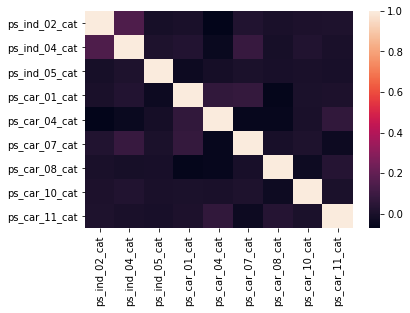

In [108]:
cat_features = [column for column in porto_data if column.endswith("cat")]
extract = porto_data[cat_features]
sns.heatmap(extract.corr())

### Num Features

In [109]:
num_features = [column for column in porto_data 
                if column not in cat_features 
                if column not in bin_features]

In [110]:
porto_data[num_features].dtypes #under comment for reviewwer's convenience

target         int64
ps_ind_01      int64
ps_ind_03      int64
ps_ind_14      int64
ps_ind_15      int64
ps_reg_01    float64
ps_reg_02    float64
ps_reg_03    float64
ps_car_11    float64
ps_car_12    float64
ps_car_13    float64
ps_car_14    float64
ps_car_15    float64
dtype: object

In [111]:
num_features #under comment for reviewer's convenience

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

<AxesSubplot:>

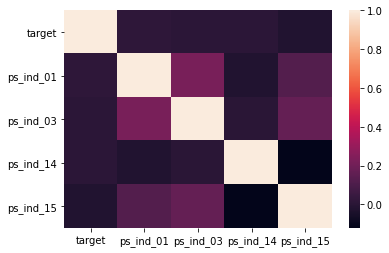

In [112]:
extract = porto_data[['target', 'ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15']]
sns.heatmap(extract.corr())

In [113]:
extract.corr()

,target,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15
target,1.000000,0.018570,0.008360,0.007443,-0.021506
ps_ind_01,0.018570,1.000000,0.223408,-0.024971,0.122137
ps_ind_03,0.008360,0.223408,1.000000,0.001990,0.170449
ps_ind_14,0.007443,-0.024971,0.001990,1.000000,-0.121547
ps_ind_15,-0.021506,0.122137,0.170449,-0.121547,1.000000


In [114]:
# according to the abalysis above I would suggest to delete 'ps_ind_14' to avoid multicollinearity
# and reduce number of dimentions in the model to avoid curce of dimentiality
porto_data = porto_data.drop(columns=['ps_ind_14'])

<AxesSubplot:>

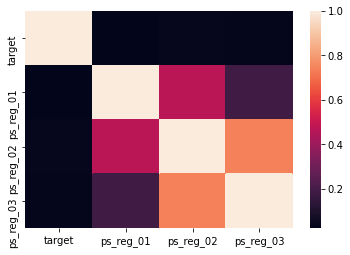

In [115]:
extract = porto_data[
    ['target', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03']]
sns.heatmap(extract.corr())

In [116]:
extract.corr()

,target,ps_reg_01,ps_reg_02,ps_reg_03
target,1.000000,0.022888,0.034800,0.033758
ps_reg_01,0.022888,1.000000,0.471027,0.189040
ps_reg_02,0.034800,0.471027,1.000000,0.742668
ps_reg_03,0.033758,0.189040,0.742668,1.000000


In [117]:
# according to the abalysis above I would suggest to delete 'ps_reg_01' to avoid multicollinearity
# and reduce number of dimentions in the model to avoid curce of dimentiality
porto_data = porto_data.drop(columns=['ps_reg_01'])

<AxesSubplot:>

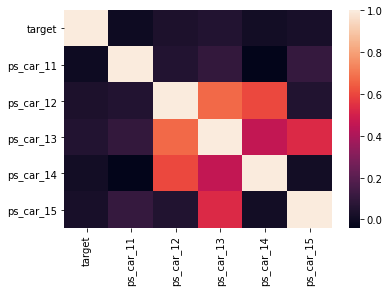

In [118]:
extract = porto_data[['target', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',  'ps_car_15']]
sns.heatmap(extract.corr())

In [119]:
extract.corr()

,target,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
target,1.000000,-0.001220,0.038800,0.053899,0.011674,0.027667
ps_car_11,-0.001220,1.000000,0.057021,0.101886,-0.039729,0.109680
ps_car_12,0.038800,0.057021,1.000000,0.672014,0.603361,0.049740
ps_car_13,0.053899,0.101886,0.672014,1.000000,0.459047,0.529519
ps_car_14,0.011674,-0.039729,0.603361,0.459047,1.000000,0.009733
ps_car_15,0.027667,0.109680,0.049740,0.529519,0.009733,1.000000


In [120]:
# according to the abalysis above I would suggest to delete 'ps_car_11' and 'ps_car_12' to avoid multicollinearity
# and reduce number of dimentions in the model to avoid curce of dimentiality
porto_data = porto_data.drop(columns=['ps_car_11', 'ps_car_12'])

In [121]:
num_features = [column for column in porto_data 
                if column not in cat_features 
                if column not in bin_features]
num_features

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_15',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

## Overview

In [122]:
porto_data.shape

(595212, 20)

In [123]:
# Columns with missing values
missing_cols = porto_data.isnull().mean()
missing_cols

target           0.000000
ps_ind_01        0.000000
ps_ind_02_cat    0.000363
ps_ind_03        0.000000
ps_ind_04_cat    0.000139
ps_ind_05_cat    0.009760
ps_ind_07_bin    0.000000
ps_ind_15        0.000000
ps_ind_17_bin    0.000000
ps_reg_02        0.000000
ps_reg_03        0.181065
ps_car_01_cat    0.000180
ps_car_04_cat    0.000000
ps_car_07_cat    0.019302
ps_car_08_cat    0.000000
ps_car_10_cat    0.000000
ps_car_11_cat    0.000000
ps_car_13        0.000000
ps_car_14        0.071605
ps_car_15        0.000000
dtype: float64

In [124]:
nan_rows = porto_data[porto_data['ps_ind_04_cat'].isnull()]
rows_to_miss_1 = nan_rows[nan_rows['target'] == 0]['target'].count() / porto_data[porto_data['target'] == 1]['target'].count()
rows_to_miss_1 #not huge %%, so let's remove, especially the same rows have missing values in other columns

0.002304784733105928

<AxesSubplot:>

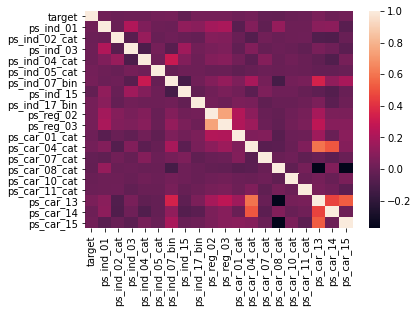

In [125]:
sns.heatmap(porto_data.corr())

In [126]:
porto_data.corr()['target'].sort_values

<bound method Series.sort_values of target           1.000000
ps_ind_01        0.018570
ps_ind_02_cat    0.005574
ps_ind_03        0.008360
ps_ind_04_cat    0.010146
ps_ind_05_cat    0.032254
ps_ind_07_bin    0.034218
ps_ind_15       -0.021506
ps_ind_17_bin    0.037053
ps_reg_02        0.034800
ps_reg_03        0.033758
ps_car_01_cat    0.017290
ps_car_04_cat    0.032900
ps_car_07_cat   -0.019735
ps_car_08_cat   -0.020342
ps_car_10_cat    0.001038
ps_car_11_cat    0.006129
ps_car_13        0.053899
ps_car_14        0.011674
ps_car_15        0.027667
Name: target, dtype: float64>

In [127]:
# ps_reg_03 is correlcated with ps_reg_02 and has 18.1% of missing values, so I would drop this feature
# ps_ind_02_cat - categorical with missing values with not much correlation
# Log reg with L1 shoerd zero coef for ps_car_15, so remove
porto_data = porto_data.drop(columns=['ps_reg_03', 'ps_ind_02_cat', 'ps_car_15'])

In [128]:
# missing values replcace with (-1)
porto_data.fillna(-1, inplace=True)

# Modelling

In [129]:
# The classes are unbalanced, so let's make dataset balanced
porto_1 = porto_data[porto_data['target'] == 1]
rows_n = porto_1['target'].count()
porto_0 = porto_data[insurance_data['target'] == 0]
porto_0 = porto_0.sample(n=rows_n, random_state=42)


In [130]:
porto = pd.concat([porto_1, porto_0]) 

In [131]:
porto.columns

Index(['target', 'ps_ind_01', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_ind_07_bin', 'ps_ind_15', 'ps_ind_17_bin', 'ps_reg_02',
       'ps_car_01_cat', 'ps_car_04_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_13', 'ps_car_14'],
      dtype='object')

In [132]:
# defining data for modelling
y_ = porto['target']
x_ = porto.drop(columns=['target'])

In [133]:
# classify columns
cat_features = [column for column in x_ if (column.endswith("cat"))]
bin_features =  [column for column in x_ if column.endswith("bin")]
num_features = [column for column in x_ 
                if column not in cat_features 
                if column not in bin_features]

In [134]:
porto_data[num_features].dtypes

ps_ind_01      int64
ps_ind_03      int64
ps_ind_15      int64
ps_reg_02    float64
ps_car_13    float64
ps_car_14    float64
dtype: object

In [135]:
ord_features = ['ps_ind_01', 'ps_ind_03', 'ps_ind_15'] #ordinal
num_features = [column for column in num_features 
                if column not in ord_features] #re-assigning continiuos features

In [136]:
# transformers
cat_transformer = OneHotEncoder(handle_unknown='ignore')
bin_transformer = OneHotEncoder(handle_unknown='ignore') # just to make sure
num_transformer = StandardScaler()
ord_transformer = MinMaxScaler()

In [137]:
preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('num', num_transformer, num_features),
        ('ord', ord_transformer, ord_features),
        ('cat', cat_transformer, cat_features),
        ('bin', bin_transformer, bin_features),
    ])

In [138]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

In [139]:
# x_train, x_valid, y_train, y_valid = train_test_split(x_, y_, test_size=0.3, random_state=42)
#модель сначала калибровалась с train/valid сплитом, потом на CV перешла

In [140]:
# pipeline.fit(x_train, y_train)
pipeline.fit(x_, y_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ps_reg_02', 'ps_car_13',
                                                   'ps_car_14']),
                                                 ('ord', MinMaxScaler(),
                                                  ['ps_ind_01', 'ps_ind_03',
                                                   'ps_ind_15']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ps_ind_04_cat',
                                                   'ps_ind_05_cat',
                                                   'ps_car_01_cat',
                                                   'ps_car_04_cat',
                                                   'ps

In [141]:
# y_pred=pipeline.predict_proba(x_valid)[:, 1]
y_pred=pipeline.predict_proba(x_)[:, 1]

In [142]:
# disp = plot_confusion_matrix(pipeline, x_valid, y_valid,
#                              cmap=plt.cm.Blues,
#                              normalize=None)

In [143]:
x_.columns

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_ind_07_bin', 'ps_ind_15', 'ps_ind_17_bin', 'ps_reg_02',
       'ps_car_01_cat', 'ps_car_04_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_13', 'ps_car_14'],
      dtype='object')

In [144]:
# and cross-validation according to the requirements
accuracy = cross_val_score(pipeline, x_, y_, scoring='accuracy', cv=5).mean()
print('accuracy: ', accuracy)

accuracy:  0.5872130290803573


In [145]:
gini_normalized(y_, y_pred)

0.26498687387551384